In [102]:
import pandas as pd
import numpy as np
import dateutil.parser as dp
from datetime import datetime as dt
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt
import seaborn as sns

Dataframe dimension:  (16663, 3)


<AxesSubplot:>

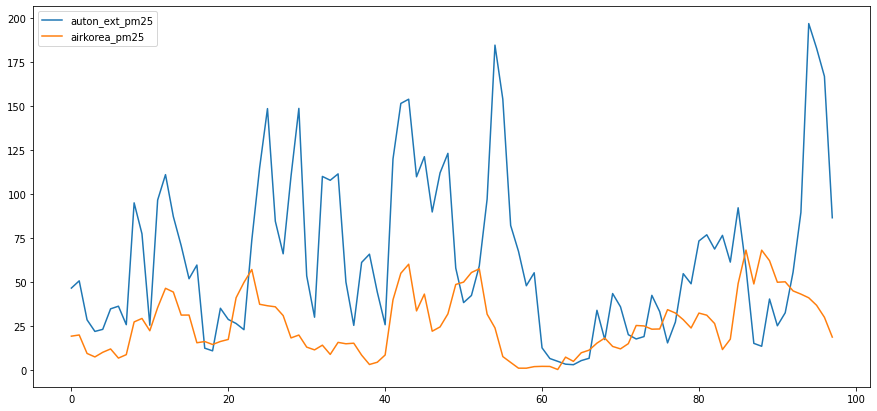

In [113]:


filepath = "./data/44_2022-3-1_2022-3-28_pm25.csv"
pm_data = pd.read_csv(filepath, header=0, parse_dates=[0], index_col="date")
print("Dataframe dimension: ", pm_data.shape)


# data group by hours
pm_data_hours = pd.DataFrame() #stack mean value for every hours (3/1~3/28)
h_date = []
h_auton_ext_pm25 = []
h_airkorea_pm25 = []
for d in range(27):
    for h in range(24):
        str_h = str(h).zfill(2)
        str_d = str(d+2).zfill(2)
        start = "2022-03-{} {}:00:00".format(str_d, str_h)
        end = "2022-03-{} {}:59:59".format(str_d, str_h)

        h_date.append(start)
        h_auton_ext_pm25.append(pm_data[start:end]['auton_ext_pm25'].mean())
        h_airkorea_pm25.append(pm_data[start:end]['airkorea_pm25'].mean())

pm_data_hours = pd.DataFrame({"date":h_date, "auton_ext_pm25":h_auton_ext_pm25, "airkorea_pm25":h_airkorea_pm25}).dropna()
pm_data_hours = pm_data_hours.reset_index(drop=True)
pm_data_hours.plot(figsize=(15,7))



ShapiroResult(statistic=0.9211322665214539, pvalue=1.94105214177398e-05)
KstestResult(statistic=0.9982121751731622, pvalue=1.068750803837625e-269)


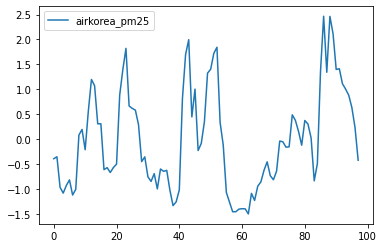

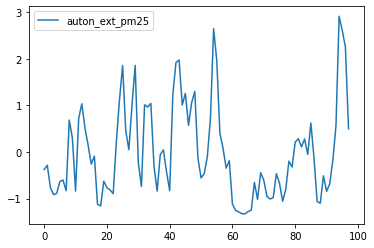

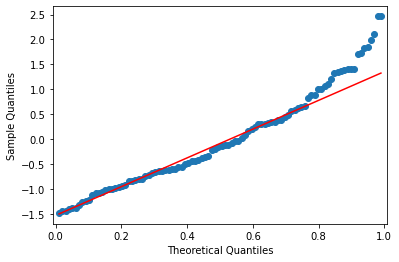

In [121]:
# apply z-score normalization
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

airkorea_pm25_z = stats.zscore(pm_data_hours[["airkorea_pm25"]])
auton_ext_pm25_z = stats.zscore(pm_data_hours[["auton_ext_pm25"]])
airkorea_pm25_z.plot()
auton_ext_pm25_z.plot()

pm_data_hours_z = pd.DataFrame({"auton_ext_pm25":auton_ext_pm25_z["auton_ext_pm25"], "airkorea_pm25":airkorea_pm25_z["airkorea_pm25"]})
pm_data_hours_z = pm_data_hours.reset_index(drop=True)

sm.qqplot(airkorea_pm25_z["airkorea_pm25"], line='q', dist=stats.uniform)
#res = stats.probplot(airkorea_pm25_z["airkorea_pm25"].values.tolist(), plot=plt)

shapiro_test = stats.shapiro(auton_ext_pm25_z)
print(shapiro_test)

print(stats.kstest(auton_ext_pm25_z, 'norm'))

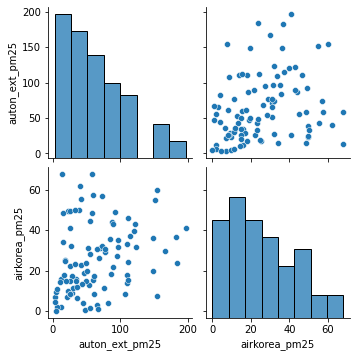

PLCC :
                 auton_ext_pm25  airkorea_pm25
auton_ext_pm25        1.000000       0.266141
airkorea_pm25         0.266141       1.000000
(0.2661413524681531, 0.00807747223902482)
SROCC :
                 auton_ext_pm25  airkorea_pm25
auton_ext_pm25         1.00000        0.32518
airkorea_pm25          0.32518        1.00000
SpearmanrResult(correlation=0.3251800304131639, pvalue=0.0010866111090547105)
SROCC :
                 auton_ext_pm25  airkorea_pm25
auton_ext_pm25        1.000000       0.230195
airkorea_pm25         0.230195       1.000000
KendalltauResult(correlation=0.23019463567692097, pvalue=0.0007855695111494167)


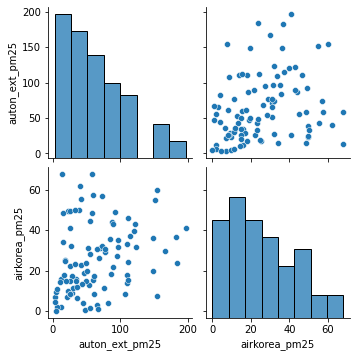

PLCC :
                 auton_ext_pm25  airkorea_pm25
auton_ext_pm25        1.000000       0.266141
airkorea_pm25         0.266141       1.000000
(0.2661413524681531, 0.00807747223902482)
SROCC :
                 auton_ext_pm25  airkorea_pm25
auton_ext_pm25         1.00000        0.32518
airkorea_pm25          0.32518        1.00000
SpearmanrResult(correlation=0.3251800304131639, pvalue=0.0010866111090547105)
SROCC :
                 auton_ext_pm25  airkorea_pm25
auton_ext_pm25        1.000000       0.230195
airkorea_pm25         0.230195       1.000000
KendalltauResult(correlation=0.23019463567692097, pvalue=0.0007855695111494167)


In [123]:
# pearson correlation with airkorea and auton data
source = pm_data_hours.loc[:, ['auton_ext_pm25', 'airkorea_pm25']]
sns.pairplot(data=source)
plt.show()

corr_pearson = source.corr(method='pearson')
print('PLCC :\n', corr_pearson)
print(stats.pearsonr(source['auton_ext_pm25'], source['airkorea_pm25']))

corr_spearman = source.corr(method='spearman')
print('SROCC :\n', corr_spearman)
print(stats.spearmanr(source['auton_ext_pm25'], source['airkorea_pm25']))

corr_kendall = source.corr(method='kendall')
print('SROCC :\n', corr_kendall)
print(stats.kendalltau(source['auton_ext_pm25'], source['airkorea_pm25']))


source_z = pm_data_hours_z.loc[:, ['auton_ext_pm25', 'airkorea_pm25']]
sns.pairplot(data=source)
plt.show()

corr_pearson = source_z.corr(method='pearson')
print('PLCC :\n', corr_pearson)
print(stats.pearsonr(source_z['auton_ext_pm25'], source_z['airkorea_pm25']))

corr_spearman = source_z.corr(method='spearman')
print('SROCC :\n', corr_spearman)
print(stats.spearmanr(source_z['auton_ext_pm25'], source_z['airkorea_pm25']))

corr_kendall = source_z.corr(method='kendall')
print('SROCC :\n', corr_kendall)
print(stats.kendalltau(source_z['auton_ext_pm25'], source_z['airkorea_pm25']))






In [58]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV #for k value
from sklearn.metrics import mean_squared_error
import math
from sklearn.ensemble import BaggingRegressor

# grid search method with knn
gridsearch = GridSearchCV(estimator=KNeighborsRegressor(), param_grid={'n_neighbors': range(1, 3), 'weights': ['distance']})
trainset, testset = train_test_split(pm_data_hours, test_size = 0.3, shuffle=True)
gridsearch.fit(trainset[["airkorea_pm25"]], trainset[["auton_ext_pm25"]])

print(gridsearch.best_params_)

train_preds_grid = gridsearch.predict(trainset[["airkorea_pm25"]])
train_mse = mean_squared_error(trainset[["auton_ext_pm25"]], train_preds_grid)
train_rmse = math.sqrt(train_mse)
test_preds_grid = gridsearch.predict(testset[["airkorea_pm25"]])
test_mse = mean_squared_error(testset[["auton_ext_pm25"]], test_preds_grid)
test_rmse = math.sqrt(test_mse)

# print(train_rmse)
# print(test_rmse)

# print(testset[["auton_ext_pm25"]].shape)
# print(test_preds_grid)


# bagging
best_k = gridsearch.best_params_["n_neighbors"]
best_weights = gridsearch.best_params_["weights"]
bagged_knn = KNeighborsRegressor(n_neighbors=best_k, weights=best_weights)
bagging_model = BaggingRegressor(bagged_knn, n_estimators=100)
bagging_model.fit(trainset[["airkorea_pm25"]], trainset[["auton_ext_pm25"]])
test_preds_grid = bagging_model.predict(testset[["airkorea_pm25"]])
test_mse = mean_squared_error(testset[["auton_ext_pm25"]], test_preds_grid)
test_rmse = math.sqrt(test_mse)
print(test_rmse)

# model = KNeighborsRegressor(n_neighbors=3, weights = "distance", metric="minkowski", metric_params={"p":4})
# model.fit(trainset[["airkorea_pm25"]], trainset[["auton_ext_pm25"]])

#model.predict(testset[["airkorea_pm25"]])

{'n_neighbors': 2, 'weights': 'distance'}
46.47332295371629


/Users/byunghunhwang/dev/mlpack/venv/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


In [60]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=4, random_state=531, n_estimators=150)

pm_data_hours
X_train, X_test, y_train, y_test = train_test_split(pm_data_hours[["airkorea_pm25"]], np.ravel(pm_data_hours[["auton_ext_pm25"]]), test_size=0.33, shuffle=False)

regr.fit(trainset[["airkorea_pm25"]], trainset[["auton_ext_pm25"]])
prediction = regr.predict(testset[["airkorea_pm25"]])
test_mse = mean_squared_error(testset[["auton_ext_pm25"]], prediction)
test_rmse = math.sqrt(test_mse)
print("rmse : ", test_rmse)
#featureImportance = regr.feature_importances_

rmse :  43.12316930918927


/var/folders/sw/_f153vnd2r346vpzbbsdw6rh0000gn/T/ipykernel_35488/3250187363.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(trainset[["airkorea_pm25"]], trainset[["auton_ext_pm25"]])
